# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision
---
#### Hila Manor

## Tutorial 12 - Reflectometry
---

<img src="./assets/tut12_reflectometry.png" style="height:200px">

* <a href="https://www.researchgate.net/figure/Color-online-Synthetic-spheres-rendered-using-the-DSBRDF-model-with-parameter-values_fig1_49723204">Image Source</a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [A Physics Based Model for Images?](#-A-Physics-Based-Model-for-Images)
* [Radiometry - Measuring Light](#-Radiometry---Measuring-Light)
* [Some Geometry](#-Some-Geometry)
* [BRDF - Bidirectional Reflectance Distribution Function](#-BRDF---Bidirectional-Reflectance-Distribution-Function)
  * [BRDF Properties](#-BRDF-Properties)
  * [Known BRDFs](#-Known-BRDFs)
  * [Mini Excercise](#Mini-Excercise)
  * [Excercise 1](#-Excercise-1)
* [Recovering Shapes from Shading](#-Recovering-Shapes-from-Shading)
  * [Known Source of Light](#-Known-Source-of-Light)
  * [ Unkown Source of Light](#-Unkown-Source-of-Light)
  * [Excercise 2](#-Excercise-2)
* [Code Time](#---------------------------CODE-TIME--------------------------)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [2]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import os
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

##  <img src="https://img.icons8.com/bubbles/50/000000/prism.png" style="height:50px;display:inline"> A Physics Based Model for Images
---
We can think of the image as a function of 3 properties of what we're looking at:
$$\text{Image intensity} = f(\text{normal}, \text{surface reflectance}, \text{illumination})$$
* The **shape** of the object - by the normal of a little patch of the surface
* The **surface's properties** that affect the light - by the surface reflectance
* The **illumination** of the scene - the direction and the type of light that's coming in.

## <img src="https://img.icons8.com/bubbles/50/000000/light-on.png" style="height:50px;display:inline"> Radiometry - Measuring Light
---
* **Radiant Flux** $\Phi(W,X)$ - The energy of a source passing through an $X$ sized loop, angled at $W$.
  * $W$ - Power (Watts!)
  * What do we get if we normailize by $|X|$?
  $$\frac{\Phi(W,X)}{|X|}=E_{\hat{n}}(W,x)$$
* **Irradiance** $E_{\hat{n}}(W,x)$ - The energy arrriving at the lighted surface (from all possible directions).
  * $\frac{W}{m^2}$ - Power per unit area
  * Does light have volume?


  $$\frac{E_{\hat{n}}(W,x)}{|W|}=L_{\hat{n}}(\hat{\omega},x)$$
* **Radiance** $L$ - The energy arriving at the lighted surface on a signle ray of light (from a single direction).
  * This is equivelent to saying that radiance is the energy carried by a signel ray of light.
    * can also be used to measure outgoing energy!
  * $\frac{W}{m^2\cdot sr}$ - Power per **projected** unit area 
  * $L_{\hat{n}}(\hat{\omega},x)$ - This radiance is stil dependant on the light's direction, so:
  $$L_{\hat{n}}(\hat{\omega},x)=L(\hat{\omega},x)\cos{\theta}$$
  * $L(\hat{\omega},x)$ - This radiance is **not** dependant on the light's direction.
    * Think of  it as fortshortening - $$E_{\hat{n}}(W,x)=L(\hat{\omega},x)\cos{\theta}|W|$$
    * flashlight example!

##### Radiance properties
* Integration relations:
$$\Phi(W,X) = \int_X\int_X L(\hat{\omega},x) \cos{\theta}d\omega dA = \int_X E_{\hat{n}}(W,x) dA$$


* Radiance remains constant along rays through empty space:
$$L(\hat{\omega},x) = L(\hat{\omega},x + \hat{\omega})$$

##  <img src="https://img.icons8.com/bubbles/50/000000/trigonometry.png" style="height:50px;display:inline"> Some Geometry
---

<img src="./assets/tut12_Geometry-for-the-definition-of-the-BRDF.png" style="height:300px">

$\theta_i$ and $\phi_i$ represent the incoming (**i**ncident) beam of light's direction, and they can both be represented as the vector $\vec{\omega_{in}}$.  
$\theta_{r}$ and $\phi_{r}$ represent the reflected beam of light's direction.
The viewing direction of our model is represented as the vector $\vec{\omega_{out}}$. 

* Why in this picture $\vec{\omega_{out}}$ is the representation of $\theta_{r}$ and $\phi_{r}$?
  * We're talking about reflectometry! We're usually looking at the reflected beam.

## <img src="https://img.icons8.com/bubbles/50/000000/minimum-value.png" style="height:50px;display:inline"> BRDF - Bidirectional Reflectance Distribution Function
---
BRDF is the ratio of outgoing energy to incoming energy at one point, in different directions.
$$f(\vec{\omega_{in}}, \vec{\omega_{out}}) = 
f(\theta_i,\phi_i; \theta_r,\phi_r) = 
\frac{\text{outgoing energy}}{\text{incoming energy}}=
\frac{L^{\text{surface}}(\theta_r,  \phi_r)}{E^{\text{surface}}(\theta_i, \phi_i)}$$

* Measured in $\frac{1}{sr}$

### <img src="https://img.icons8.com/bubbles/50/000000/edit-property.png" style="height:50px;display:inline"> BRDF Properties
---
* **Conservation of Energy** -   $$\forall\hat{\omega}_{in},  \quad  \int{ f(\vec{\omega_{in}}, \vec{\omega_{out}}) \cos{\theta_{out}}d\hat{\omega}_{out}}\le 1$$
  * Where is the $\cos{\theta_{out}}$ coming from?
    * It's because of foreshortening!
  * Why is it ≤?
    * The object can absorb energy!
  * What about focusing lenses? the focused light is brighter than the original rays!
    * The bright spot comes from integrating over different lights, but we're talking here about one particular incoming direction.
  * Full expression  (insert the Jacobian): $$\int_{\phi_{out}=0}^{2\pi}{\int_{\theta_{out}=0}^{\frac{\pi}{2}}{ f(\vec{\omega_{in}}, \vec{\omega_{out}}) \cos{\theta_{out}} \sin{\theta_{out}} d\theta_{out}d\phi_{out}}} \le 1$$

### <img src="https://img.icons8.com/bubbles/50/000000/edit-property.png" style="height:50px;display:inline"> BRDF Properties
---
* **Helmholtz  Reciprocity** - $f(\vec{\omega_{in}}, \vec{\omega_{out}}) = f(\vec{\omega_{out}}, \vec{\omega_{in}})$  
  The BRDF Doesn't change if the source point of light and the viewing direction swap
* **Isotrpy (Rotational Symmetry)** - $f(\vec{\omega_{in}}, \vec{\omega_{out}}) = f(\theta_i, \theta_r, \phi_i-\phi_r)$  
  Under this (common) assumption, rotating the incident beam and the reflected beam around the normal to the surface doesn't change the BRDF.
    * The tilt angle still matters!
* **Radiance Calculation** - $$L^{out}(\hat{\omega}) = \int_{\Omega_{in}} f(\hat{\omega}_{in}, \hat{\omega}_{out})L^{in}(\hat{\omega}_{in}) \cos{\theta}_{in} d\hat{\omega}_{in}$$

### <img src="https://img.icons8.com/bubbles/50/000000/info.png" style="height:50px;display:inline"> Known BRDFs
---
####  Specular
A specular surface will reflect all of the incident light in a single direction, visible only when $\vec{\omega_{view}}=\vec{\omega_{reflected}}$.
* This describes a mirror.
$$f(\theta_i,\phi_i; \theta_v,\phi_v) = \rho_s \underbrace{\delta (\theta_i - \theta_v)}_{\text{same tilt}} \underbrace{\delta(\phi_i+\pi-\phi_v)}_{\text{same plane}}$$
* $\rho_s$ - is the specular albedo (e.g. a darkened mirror)
$$L=I \rho_s \delta (\theta_i - \theta_v) \delta(\phi_i+\pi-\phi_v)$$

#### Lambertian Surfaces
A lambertian surface will seem equally bright from all viewing directions.
* Think of  it as an ideal 'matte' surface. 
$$f(\vec{\omega_{in}}, \vec{\omega_{out}}) = \frac{a}{\pi}$$ 
* $a$ (sometimes $\rho_d$) is the **albedo**, which satisfies $a\le1$.
$$L = \frac{a}{\pi} I \cos{\theta_i}=a I(\vec{n}\cdot \vec{\omega_{in}})$$

---
You can model many objects using a combination of specular and lambertian components.

#### Mini-Excercise

* What are the surfaces types shown in the diagrams below?
<img src="./assets/tut12_reflection_types.png" style="height150px">

**Solution**
* 1st: Isotropic
  * The outgoing light (radiance) is the same in all directions
* 2nd: Lambertian (Diffuse)
  * The outgoing light (radiance) is dependant on the direction relative to the surface's normal, which means the object will appear equally iluminated from all directions.
  * Think of it in the context of fortshortening: 
    * When you look at the surface from the side, it will appear to have bigger surface area - that way you integrate "weaker" rays over a big area. 
    * When you look at the surface from its front - you will see the true small surface area, and will only integrate on a few "stronger" rays.
    * This way, the total integration stays the same from different viewing angles (And the object appears equally bright...).
* 3rd: Specular
  * All of the incoming light is going out in a single output direction, with the same tilt relative to the normal to the surface.
  
  
* How would the diagram of a completely absorbing surface would look? What is its BRDF function?

### <img src="https://img.icons8.com/bubbles/50/000000/create-new.png" style="height:50px;display:inline"> Excercise 1
---
* Prove that $0\le a \le 1$.

We know from the convservation of energy that: $$\forall\hat{\omega}_{in},  \quad  \int{ f(\vec{\omega_{in}}, \vec{\omega_{out}}) \cos{\theta_{out}}d\hat{\omega}_{out}}\le 1$$

Swap in the BRDF of a lambertian surface:
$$f(\vec{\omega_{in}}, \vec{\omega_{out}}) = \frac{a}{\pi}$$

We get:
 $$\forall\hat{\omega}_{in},  \quad  \int{ \frac{a}{\pi}\cos{\theta_{out}}d\hat{\omega}_{out}}\le 1$$
 $$\forall\hat{\omega}_{in},  \quad  \frac{a}{\pi} \int{ \cos{\theta_{out}}d\hat{\omega}_{out}}\le 1$$
Reminder (jacobian):
$$\frac{a}{\pi} \int_{\phi_{out}=0}^{2\pi}{\int_{\theta_{out}=0}^{\frac{\pi}{2}}{ \cos{\theta_{out}} \sin{\theta_{out}} d\theta_{out}d\phi_{out}}}\le 1$$
$$\frac{a}{\pi} \cdot \frac{1}{2}\cdot 2\pi \le 1$$
$$a\le1$$

## <img src="https://img.icons8.com/bubbles/50/000000/rhomboid-shape.png" style="height:50px;display:inline"> Recovering Shapes from Shading
---
### <img src="https://img.icons8.com/bubbles/50/000000/softbox.png" style="height:50px;display:inline"> Known Source of Light
---
* We assume a **lambertian** BRDF and a **known** directional source of light.

using the equation for a single pixel image value - $$I=\frac{a}{\pi}\hat{n}^T\cdot\vec{\mathscr{l}}$$
We can create a matrix equation:
$$\underbrace{\left[\begin{matrix} I_1  \\ I_2  \\ \vdots \\ I_N  \\ \end{matrix} \right]}_{I} = 
\frac{a}{\pi} \underbrace{\left[ \begin{matrix} \vec{\mathscr{l}}^T_1 \\ \vec{\mathscr{l}}^T_2 \\ \vdots \\ \vec{\mathscr{l}}^T_N \end{matrix} \right]}_{L} \hat{n}$$
and by setting $\tilde{n}=\frac{a}{\pi}\hat{n}$ we can solve via an inverse solution for 3 source or LS for N sources:
$$I=L\tilde{n}$$
$$L^TI=l^TL\tilde{n}$$
$$\tilde{n}=(L^TL)^{-1}L^TI \longrightarrow a=\pi|\tilde{n}| \quad n=\frac{\pi\tilde{n}}{a}$$

Why do we care about the normals?
* You've seen in the lecutre that from them you can get the depth image's derivatives!
  * Each normal gives 2 linear constraints on, thus you can solve for z using SVD.

### <img src="https://img.icons8.com/bubbles/50/000000/question-mark.png" style="height:50px;display:inline"> Unkown Source of Light
---
As you've seen in the leture, we can use all the pixels in the image ($M$) simultaniously:
$$\left[\begin{matrix} I_1  \\ I_2  \\ \vdots \\ I_N  \\ \end{matrix} \right]_{N\times M} = 
\left[ \begin{matrix} \vec{\mathscr{l}}^T_1 \\ \vec{\mathscr{l}}^T_2 \\ \vdots \\ \vec{\mathscr{l}}^T_N \end{matrix} \right]_{N\times3} [\tilde{N}]_{3\times M}$$
and solve via SVD.
* The results aren't unique!
  * How many degrees of freedom are there? Why?

### <img src="https://img.icons8.com/bubbles/50/000000/create-new.png" style="height:50px;display:inline"> Excercise 2
---
You are provided in the lab a surface made of an experimental material whose BRDF function is given by
$$f(\vec{\omega_{in}}, \vec{\omega_{out}}) = \rho_{experimental}\cdot\frac{1}{\cos{\theta_i}}$$
$\theta_i$ is the tilt angle as before.

1. Will the appearance of this surface vary with the viewing direction?
2. Will it vary with the incoming light direction? 
3. Will we be able to use photometric stereo to reconstruct an object made of this material?

#### solution
1. $$L^{out}(\hat{\omega}) = \int_{\Omega_{i}} f(\hat{\omega}_{i}, \hat{\omega}_{out})L^{in}(\hat{\omega}_{i}) \cos{\theta}_{i} d\hat{\omega}_{i} = $$
$$ = \int_{\Omega_{i}} \rho_{experimental}\cdot\frac{1}{\cos{\theta_i}}L^{in}(\hat{\omega}_{i}) \cos{\theta}_{i} d\hat{\omega}_{i} = \rho_{experimental}L^{in}$$
  The outgoing radiance is independent on the vieweing direction, so no.
2. the outgoing radiance $= \rho_{experimental}L^{in}$, again independent on the incident light direction, so no.
3. No. The outgoing radiance will be the same in all of the images, as it's independent of the angle between the incident beam direction (or viewing direction) and the surface normal.

# ------------------------- <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> CODE TIME -------------------------

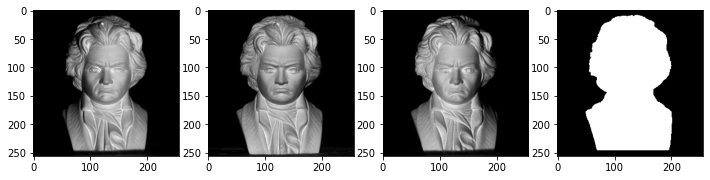

In [3]:
# Load the experiment's data
experiment_path = './assets/tut12_reflect_bet'
ims = []
for im_path in os.listdir(experiment_path):
    ims.append(plt.imread(os.path.join(experiment_path, im_path)))
im_amount = len(ims)
mask = plt.imread('./assets/tut12_reflect_bet_mask.png').astype(np.bool)
               
plt.figure(figsize=(12,5))
for i in range(im_amount):
    plt.subplot(1,im_amount + 1, i + 1)
    plt.imshow(ims[i], 'gray')
plt.subplot(1,im_amount + 1, im_amount + 1)
_ = plt.imshow(mask, 'gray')

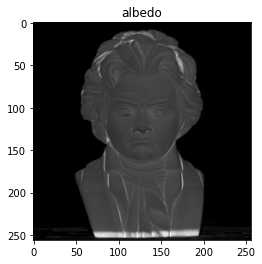

In [4]:
# The lights were known (calibrated at the lab)
L = np.array([[0.0814, 0.2577, 1],
              [-0.1953, -0.0166, 0.9669],
              [0.1061, -0.2809, 1.0397]])

# Create a 3xM I matrix.
I = np.vstack([im.ravel() for im in ims])

# Calculate the pseudo-normal
n_tilde = np.linalg.inv(L).dot(I)

# Extract the albedo
#a = np.pi*np.linalg.norm(n_tilde, axis=0).reshape(ims[0].shape)
a = np.linalg.norm(n_tilde, axis=0).reshape(ims[0].shape)
plt.imshow(a, 'gray')
_ = plt.title('albedo')

In [5]:
# Extract the normals
#n  = np.pi * n_tilde / a.ravel()
n  = n_tilde / a.ravel()
n_3d = n.reshape((3, *ims[0].shape)).transpose(1,2,0)

# get the normal to the derivatives form (df/dx, df/dy, -1)
dvs = n_3d / (-n_3d[:,:,2].reshape((*ims[0].shape, -1)))


In [6]:
def tolist(A):
    """
    Linearize array to a 1D list
    """
    return list(np.reshape(A, A.size))

def unbiased_integrate(dx, dy, mask):
    """
    Constructs the finite difference matrix, domain and other information
    for solving the Poisson system and solve it. Port of Yvain's implementation, 
    even  respecting the comments :-)
    
    Arguments:
    ----------
    dx, dy, mask: numpy arrays
        all arrays must have the same size, say (m,n)
        dx, dy are the derivatives of the surface, obtained by 
        solving the system formed by the light sources and measured intensities,
        and then after albedo normalization.
    
    Returns:
    -------
    z: numpy array
        array of size (m,n), with computed depth values inside the 
        make region (mask > 0) and NaN (Not a Number) in the region mask == 0.
    It solves for the system comming from the discretization of
           -Laplacian(z) - Divergence(n1/n3, n2/n3) = 0
    with some boundary conditions, it gives a discretized Poisson system
        AZ = b
    and z is obtained by mapping the values in Z to the region of the 2D image
    of size (m,n) where mask > 0. The rest of the z-image values are set to NaN.
    """

    # Calculate some usefuk masks
    m,n = mask.shape
    Omega = np.zeros((m,n,4))
    Omega_padded = np.pad(mask, (1,1), mode='constant', constant_values=0)
    Omega[:,:,0] = Omega_padded[2:,1:-1]*mask
    Omega[:,:,1] = Omega_padded[:-2,1:-1]*mask
    Omega[:,:,2] = Omega_padded[1:-1,2:]*mask
    Omega[:,:,3] = Omega_padded[1:-1,:-2]*mask
    del Omega_padded

    # Mapping    
    indices_mask = np.where(mask > 0)
    lidx = len(indices_mask[0])
    mapping_matrix = np.zeros(dx.shape, dtype=int)
    mapping_matrix[indices_mask] = range(lidx)

    dxbar = 0.5*(dx + dx[list(range(1,m)) + [m-1], :])
    dybar = 0.5*(dy + dy[:, list(range(1,n)) + [n-1]])

    # System
    I = []
    J = []
    K = []
    b = np.zeros(lidx)


    # In mask, right neighbor in mask
    rset = Omega[:,:,2]
    X, Y = np.where(rset > 0)
    #indices_center = sub2ind(mask.shape, X, Y)
    I_center = mapping_matrix[(X,Y)].astype(int)
    #indices_neighbors = sub2ind(mask.shape, X, Y+1)
    I_neighbors = mapping_matrix[(X,Y+1)]
    lic = len(X)
    A_center = np.ones(lic)
    A_neighbors = -A_center
    K += tolist(A_center) + tolist(A_neighbors)
    I += tolist(I_center) + tolist(I_center)
    J += tolist(I_center) + tolist(I_neighbors)
    b[I_center] -= dybar[(X,Y)]

    #	In mask, left neighbor in mask
    lset = Omega[:,:,3]
    X, Y = np.where(lset > 0)
    #indices_center = sub2ind(mask.shape, X, Y)
    I_center = mapping_matrix[(X,Y)].astype(int)
    #indices_neighbors = sub2ind(mask.shape, X, Y-1)
    I_neighbors = mapping_matrix[(X,Y-1)]
    lic = len(X)
    A_center = np.ones(lic)
    A_neighbors = -A_center
    K += tolist(A_center) + tolist(A_neighbors)
    I += tolist(I_center) + tolist(I_center)
    J += tolist(I_center) + tolist(I_neighbors)
    b[I_center] += dybar[(X,Y-1)]


    # In mask, top neighbor in mask
    tset = Omega[:,:,1]
    X, Y = np.where(tset > 0)
    #indices_center = sub2ind(mask.shape, X, Y)
    I_center = mapping_matrix[(X,Y)].astype(int)
    #indices_neighbors = sub2ind(mask.shape, X-1, Y)
    I_neighbors = mapping_matrix[(X-1,Y)]
    lic = len(X)
    A_center = np.ones(lic)
    A_neighbors = -A_center
    K += tolist(A_center) + tolist(A_neighbors)
    I += tolist(I_center) + tolist(I_center)
    J += tolist(I_center) + tolist(I_neighbors)
    b[I_center] += dxbar[(X-1,Y)]


    #	In mask, bottom neighbor in mask
    bset = Omega[:,:,0]
    X, Y = np.where(bset > 0)
    #indices_center = sub2ind(mask.shape, X, Y)
    I_center = mapping_matrix[(X,Y)].astype(int)
    #indices_neighbors = sub2ind(mask.shape, X+1, Y)
    I_neighbors = mapping_matrix[(X+1,Y)]
    lic = len(X)
    A_center = np.ones(lic)
    A_neighbors = -A_center
    K += tolist(A_center) + tolist(A_neighbors)
    I += tolist(I_center) + tolist(I_center)
    J += tolist(I_center) + tolist(I_neighbors)
    b[I_center] -= dxbar[(X,Y)]

    # Construction de A : 
    A = sp.csc_matrix((K, (I, J)))
    A = A + sp.eye(A.shape[0])*1e-9
    z = np.nan*np.ones(mask.shape)
    z[indices_mask] = spsolve(A, b)
    return z

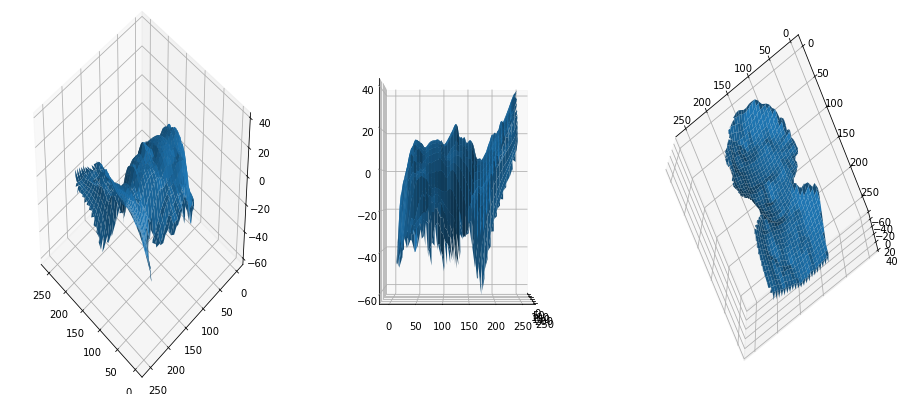

In [7]:
# Integrate the derivatives to get the surface
z = unbiased_integrate(dvs[:,:,0], dvs[:,:,1], mask)


# Plot
fig, ax = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(16,7))
X,Y = np.meshgrid(np.arange(ims[0].shape[1]), np.arange(ims[0].shape[0]))
ax[0].plot_surface(X, Y, z, vmin=np.nanmin(z), vmax=np.nanmax(z))
ax[1].plot_surface(X, Y, z, vmin=np.nanmin(z), vmax=np.nanmax(z))
ax[2].plot_surface(X, Y, z, vmin=np.nanmin(z), vmax=np.nanmax(z))
ax[0].view_init(elev=45, azim=135)
ax[1].view_init(elev=0, azim=0)
ax[2].view_init(elev=100, azim=60)

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* BRDF - <a href="https://www.youtube.com/watch?v=4QXE52mswIE">BRDF - Interactive 3D Graphics
 by Udacity</a>
 * BRDF - <a href="https://www.youtube.com/watch?v=R9iZzaXUaK4">BRDF: Bidirectional Reflectance Distribution Function, Prof. Shree Nayar,  T. C. Chang</a>
* Radiometry - <a href="https://www.youtube.com/watch?v=tflz0loWhIY">Radiometric Concepts | Radiometry and Reflectance, Prof. Shree Nayar,  T. C. Chang</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* <a href="http://queau.perso.enseeiht.fr/research.html">Solving Uncalibrated Photometric Stereo using Total Variation, JMIV '15, Yvain Quéau, Jean-Denis Durou, François Lauze</a>
* <a href="https://www.cs.cornell.edu/courses/cs4670/2018sp">Cornell's Introduction to Computer Vision</a>
* <a href="https://classroom.udacity.com/courses/ud810">Udacity's Introduction to Computer Vision</a>
* <a href="http://www.ece.ncsu.edu/imaging/Archives/ImageDatabase/">NC State University's Image Database</a>
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com